# Multivariate LSTM

In [55]:
import numpy as np, pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Load dataset
df = pd.read_csv('../../csv/Beras.csv', parse_dates=True, index_col='Tanggal')  # Ensure 'Date' is the correct column name for your index

# Fill any missing values
df.fillna(method='ffill', inplace=True)

# Select features and target
features = df.drop('Harga Beras', axis=1)  # Assuming other columns are features
target = df['Harga Beras']

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# Prepare input data for LSTM [samples, timesteps, features]
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
X, y = create_dataset(scaled_features, scaled_target, time_steps)

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_71984/3257138128.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [56]:
n_features = 9
n_timesteps = 1

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [58]:
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
17/17 [==============================] - 0s 3ms/step - loss: 9.3706e-04 - val_loss: 0.0473
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 9.3176e-04 - val_loss: 0.0434
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 9.0456e-04 - val_loss: 0.0500
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 9.0622e-04 - val_loss: 0.0432
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 8.9378e-04 - val_loss: 0.0432
Epoch 6/20
17/17 [==============================] - 0s 2ms/step - loss: 8.9236e-04 - val_loss: 0.0400
Epoch 7/20
17/17 [==============================] - 0s 2ms/step - loss: 8.9725e-04 - val_loss: 0.0444
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 8.9114e-04 - val_loss: 0.0389
Epoch 9/20
17/17 [==============================] - 0s 2ms/step - loss: 8.7450e-04 - val_loss: 0.0384
Epoch 10/20
17/17 [==============================] - 0s 3ms/step - loss: 8.6802e-0

In [59]:
# Predict the next 90 days
last_input = scaled_features[-time_steps:]  # Get the last known input
last_input = last_input.reshape((1, time_steps, scaled_features.shape[1]))
predicted = []
for _ in range(90):  # Loop for each day you want to predict
    pred = model.predict(last_input)[0]
    predicted.append(pred)
    
    # Get the last input for all features, replace the target feature with the new prediction
    new_input_features = last_input[0, -1, :].copy()  # Copy the last timestep's features
    new_input_features[0] = pred  # Assume target is at index 0, adjust if different
    
    # Reshape and concatenate
    new_input_features = new_input_features.reshape(1, 1, -1)
    last_input = np.concatenate((last_input[:, 1:, :], new_input_features), axis=1)
# Inverse transform to get actual values
predicted = scaler.inverse_transform(predicted)

1/1 [==============================] - 0s 11ms/step


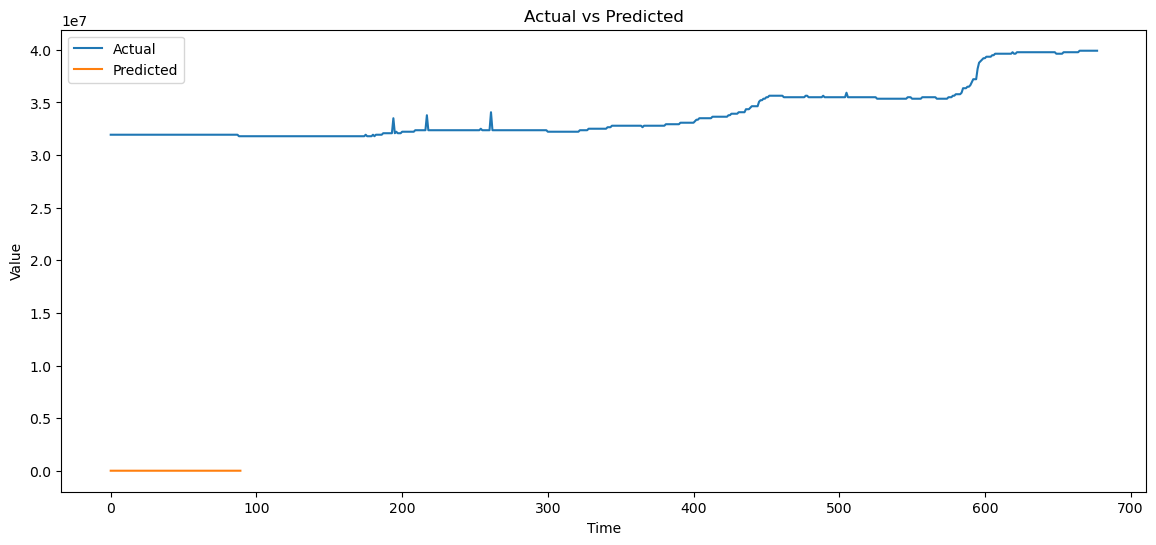

In [60]:
import matplotlib.pyplot as plt

# Assuming 'target' is your actual data
actual = scaler.inverse_transform(target.values.reshape(-1, 1))

# Plot actual data
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual')

# Plot predicted data
plt.plot(predicted, label='Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

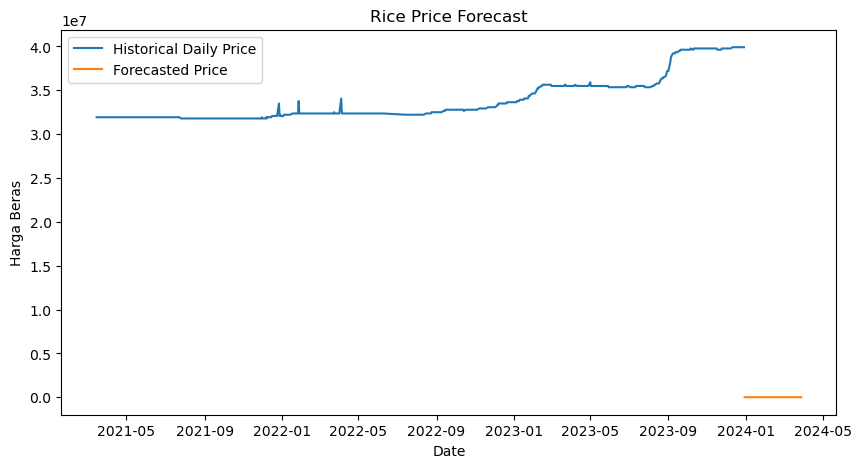

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the dates need to be generated for the forecasted period
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=90, freq='D')

plt.figure(figsize=(10, 5))
plt.plot(df.index, actual, label='Historical Daily Price')
plt.plot(forecast_dates, predicted, label='Forecasted Price')
plt.title('Rice Price Forecast')
plt.xlabel('Date')
plt.ylabel('Harga Beras')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now X_test and y_test are your testing datasets

# Assuming you have a trained model named 'model'
# And a test set X_test, y_test

# Predict on the test set
y_pred = model.predict(X_test)

# Rescale the predictions back to the original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate MSE
mse = mean_squared_error(y_test_inv, y_pred_inv)
print('Mean Squared Error: ', mse)

# Calculate MAE
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Absolute Error: ', mae)

# Calculate RMSE
rmse = sqrt(mse)
print('Root Mean Squared Error: ', rmse)

5/5 [==============================] - 0s 646us/step
Mean Squared Error:  72766.82486265547
Mean Absolute Error:  134.1703455307904
Root Mean Squared Error:  269.75326663945236
5/5 [==============================] - 0s 646us/step
Mean Squared Error:  72766.82486265547
Mean Absolute Error:  134.1703455307904
Root Mean Squared Error:  269.75326663945236


# LSTM

In [ ]:
# Select target
target = df['Harga Beras']

# Normalize target
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

# Prepare input data for LSTM [samples, timesteps, features]
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
X, y = create_dataset(scaled_target, scaled_target, time_steps)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='mse')

# Fit the model
history = model.fit(
    X, y,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/10
17/17 [==============================] - 1s 9ms/step - loss: 0.0392 - val_loss: 0.5943
Epoch 2/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.5539
Epoch 3/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.5192
Epoch 4/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.4871
Epoch 5/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.4575
Epoch 6/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.4304
Epoch 7/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.4058
Epoch 8/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0211 - val_loss: 0.3838
Epoch 9/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0204 - val_loss: 0.3642
Epoch 10/10
17/17 [==============================] - 0s 2ms/step - loss: 0.0199 - val_loss: 0.3466


22/22 [==============================] - 0s 736us/step


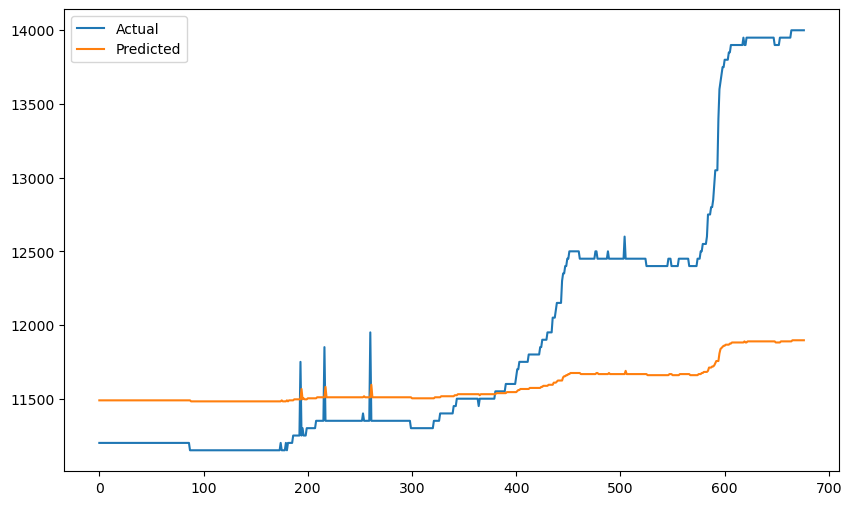

In [ ]:
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X)

# Invert scaling for forecast
inv_y_pred = scaler.inverse_transform(y_pred)

# Invert scaling for actual
y_true = scaler.inverse_transform(y)

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(y_true, label='Actual')
plt.plot(inv_y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Calculate the Mean Absolute Error
mae = mean_absolute_error(y_true, inv_y_pred)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_true, inv_y_pred)

# Calculate the Root Mean Squared Error
rmse = sqrt(mse)

print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 574.589340322655
Mean Squared Error: 693368.0679899283
Root Mean Squared Error: 832.6872570118558
